In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats as sct

from sklearn.metrics import roc_auc_score, roc_curve

In [4]:
from functools import partial, reduce

In [5]:
np.set_printoptions(precision=2)
sns.set_style('darkgrid')

# Generate data

In [6]:
class SampleGenerator:
    """ Generate simulated data """

    PROCESSES = ['poisson']

    def __init__(self, process, params, n_state, transition_mat):
      
        if (len(params) != n_state):
            raise ValueError("params count: {} is not equal to n_state: {}".format(len(params), n_state))
        
        if (transition_mat.shape[0] != n_state) or (transition_mat.shape[0] != transition_mat.shape[1]):
            raise ValueError("`transition_mat` is not square or not equal to `n_state`")

        if not np.isclose(transition_mat.sum(axis=1), 1).all():
            raise ValueError("`transition_mat` rows should add to 1")

        if process not in self.PROCESSES:
            raise NotImplementedError("`process` type of {} is not implemented".format(process))
        
        self.process_type = process
        self.process_params = params
        self.n_state = n_state
        self.transition_mat = transition_mat

    def __validate_inputs(self, n_samples, init_state):
        
        if init_state >= self.n_state:
            raise ValueError("`init_state` is greater than `n_state`:{}".format(init_state))

    def __getsample(self, params):

        if self.process_type == 'poisson':
            sample = np.random.poisson(params['lambda'])
        else:
            raise NotImplementedError("Process type not implemented")

        return sample

    def generate_samples(self, n_samples, seed = 42, init_state = 0, transition_distribution = 'uniform'):

        self.__validate_inputs(n_samples, init_state)

        curr_state = init_state
        state_history = []
        all_samples = []

        for sample_id in range(n_samples):
            
            all_samples.append(self.__getsample(self.process_params[curr_state]))
            state_history.append(curr_state)

            # do i switch?
            transition_probs = self.transition_mat[curr_state]
            draw = np.random.uniform()
            highs = transition_probs.cumsum()
            lows = np.roll(highs, shift=1)
            lows[0] = 0
            for i, (low, high) in enumerate(zip(lows, highs)):
                if (draw >= low) and (draw < high):
                    curr_state = i
                    break
        
        return np.array(all_samples), np.array(state_history)

In [49]:
n_samples = 100
t_mat = np.array([[0.8, 0.2],[0.2, 0.8]])
init = 0

sg = SampleGenerator("poisson", [{'lambda':5}, {'lambda': 10}], 2, 
                     t_mat)
vals, states_orig = sg.generate_samples(n_samples, init_state=init)

In [50]:
states_orig

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1])

In [51]:
vals

array([ 5,  2, 11,  9, 10,  4, 11, 13, 11, 10,  5,  8, 11, 13, 12,  6,  3,
        5,  3,  2,  7,  3,  4,  7,  8,  4,  3,  2,  5,  6,  7, 11,  7, 10,
        6, 10, 11,  5,  5,  7,  9, 14,  5,  3,  2, 15,  4,  9, 10, 13,  8,
       10,  8,  8, 13,  5,  2, 11,  6,  9,  5,  7,  3,  7,  9, 11, 14,  4,
       10, 14,  8,  3,  5,  7,  5,  8,  4,  7,  5,  2,  3,  9,  6, 11,  3,
       10, 12, 10, 11,  9,  6, 15, 11,  6,  7,  4, 13,  4, 11, 15])

# Forward-Backward algorithm

## Forward algorithm

In [52]:
def normalize(mat, axis=None):
    c = mat.sum(axis=axis)
    if axis==1:
        c = c.reshape(-1, 1)
    elif axis == 0:
        c = c.reshape(1, -1)
    return c, mat / c

In [53]:
def forward_pass(y, t, dists, init, trans_mat):
    
    x0 = dists[0]
    x1 = dists[1]
    all_c = []
    if t == 0:
        O = np.diag([x0.pmf(y[0]), x1.pmf(y[0])])
        c, normed = normalize(O @ init)
        return c, normed.reshape(1, -1)
        
    else:
        c_tm1, alpha_tm1 = forward_pass(y, t - 1, dists, init, trans_mat)
        
        O = np.diag([x0.pmf(y[t]), x1.pmf(y[t])])
        c, normed = normalize(O @ trans_mat.T @ alpha_tm1[-1, :])
        
        return c_tm1 + c, np.row_stack([alpha_tm1, normed])
        

In [54]:
X = states_orig
y = vals
t = n_samples - 1
dists = sct.poisson(5), sct.poisson(10)
init = np.array([1, 0])
trans_mat = t_mat

consts, state_prob_forward = forward_pass(y, t, dists, init, trans_mat)

In [55]:
roc_auc_score(X[:t+1], state_prob_forward[:,1])

0.9431239388794567

In [56]:
def plot_roc(y_true, y_pred, title, ax=None):
    
    if ax == None:
        f, ax = plt.subplots(figsize=(7,5))
        
    fpr, tpr, threshold = roc_curve(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    ax.plot(fpr, tpr, label=title + " ({:.2f})".format(auc))
    
    plt.legend(loc=4)
    return ax

<AxesSubplot:>

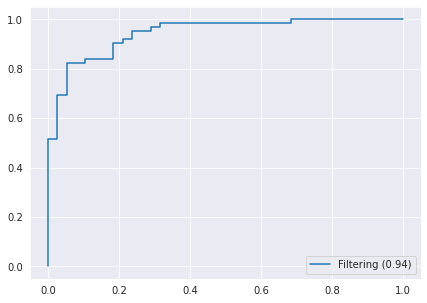

In [57]:
plot_roc(X, state_prob_forward[:,1], "Filtering", ax=None)

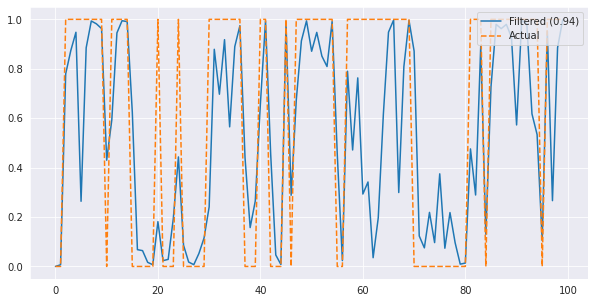

In [58]:
f, ax = plt.subplots(figsize=(10,5))
auc = roc_auc_score(X, state_prob_forward[:,1])
ax.plot(state_prob_forward[:,1], label ='Filtered ({:.2f})'.format(auc))
ax.plot(X, ls='--', label='Actual')

plt.legend(frameon=True, loc=1)
plt.show()

## Backward algorithm

In [59]:
def backward_pass(y, T, t, dists, init, trans_mat):
    
    x0 = dists[0]
    x1 = dists[1]
    all_c = []
    
    if t == T:
        c, normed = normalize(np.ones(2))
        return 0, normed.reshape(1, -1)
        #return 0, np.ones(2).reshape(1, -1)
    else:
        
        c_tm1, beta_tp1 = backward_pass(y, T, t+1, dists, init, trans_mat)
        O = np.diag([x0.pmf(y[t+1]), x1.pmf(y[t+1])])
        c, normed = normalize(trans_mat @ O @ beta_tp1[-1, :])
        
        return c_tm1 + c, np.row_stack([normed, beta_tp1])


In [60]:
c, state_prob_backward = backward_pass(y, 99, 0, dists, init, trans_mat)

In [61]:
roc_auc_score(X[:t+1], state_prob_backward[:,1])

0.7207130730050935

## Forward-backward algorithm

In [62]:
def gamma_pass(y, T, t, dists, init, trans_mat):
    
    consts_f, state_prob_forward = forward_pass(y, T, dists, init, trans_mat)
    consts_b, state_prob_backward = backward_pass(y, T, t, dists, init, trans_mat)
    
    gamma = (state_prob_backward * state_prob_forward)
    
    return gamma

In [63]:
gamma = gamma_pass(y, 99, 0, dists, init, trans_mat)
pred = np.divide(gamma, gamma.sum(axis=1).reshape(-1,1))
roc_auc_score(X[:t+1], pred[:,1])

0.9596774193548387

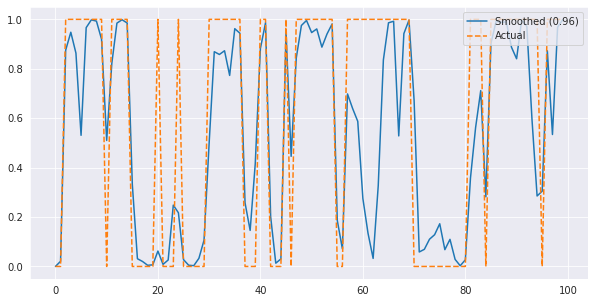

In [64]:
f, ax = plt.subplots(figsize=(10,5))
auc = roc_auc_score(X, pred[:,1])
ax.plot(pred[:,1], label ='Smoothed ({:.2f})'.format(auc))
ax.plot(X, ls='--', label='Actual')

plt.legend(frameon=True, loc=1)
plt.show()

## Two-slice marginal

In [65]:
def two_slice(y, T, t, dists, init, trans_mat):
    
    x0 = dists[0]
    x1 = dists[1]
    
    _, betas = backward_pass(y, T, t, dists, init, trans_mat)
    _, alphas = forward_pass(y, t-1, dists, init, trans_mat) 
    
    alpha = alphas[-1]
    beta = betas[0]
    
    O = np.diag([x0.pmf(y[t]), x1.pmf(y[t])])
    
    c, normed = normalize(trans_mat * (alpha @ (O * beta).T), axis=None)
    
    return c, normed
    

In [66]:
c, normed = two_slice(y, 99, 5, dists, init, trans_mat)
normed

array([[0.11, 0.17],
       [0.03, 0.69]])

# EM (Baum-Welch)

## Intialize

In [67]:
pi_init = npr.dirichlet(alpha=[0.5, 0.5])
z_init = npr.randint(0, 2, size=n_samples)
A_init = npr.dirichlet(alpha=[3, 3], size=2)
B_init = np.array([1, 20])

# E-step

In [68]:
z = z_init.copy()
A = A_init.copy()
B = B_init.copy()
pi = pi_init.copy()

print(A, B, pi)

[[0.54 0.46]
 [0.7  0.3 ]] [ 1 20] [0.97 0.03]


In [69]:
def E_step(y, A, B, pi):
    
    dists = sct.poisson(B[0]), sct.poisson(B[1])
    
    all_gammas = gamma_pass(y, 99, 0, dists, pi, A)

    En1k = all_gammas[0]
    Enjk = reduce(lambda x,y : x+y, map(lambda t: two_slice(y, 99, t, dists, pi, A)[1], range(1, 100)))
    Enj = reduce(lambda x,y: x + y, all_gammas)
    
    first_term = En1k @ np.log(pi) 
    middle_term = (Enjk * np.log(A)).sum()
    
    p_z = np.log(np.row_stack([dists[0].pmf(y), dists[1].pmf(y)]))
    final_term = (p_z * all_gammas.T).sum()
    
    like = first_term + middle_term + final_term
    
    return like, En1k, Enjk, Enj, all_gammas

In [70]:
def M_step(y, En1k, Enjk, Enj, all_gammas):

    A = Enjk / Enjk.sum(axis=1).reshape(-1, 1) 
    pi = En1k / En1k.sum()
    
    B = (all_gammas * y.reshape(-1, 1)).sum(axis=0) / Enj    

    return A, np.round(B), pi

In [71]:
np.random.seed(55)

max_iter = 100
i = 0

pi_init = np.array([0.5, 0.5]) #npr.dirichlet(alpha=[0.5, 0.5])
z_init = npr.randint(0, 2, size=n_samples)
A_init = npr.dirichlet(alpha=[0.5, 0.5], size=2)
B_init = np.array([1, 20])

z = z_init.copy()
A = A_init.copy()
B = B_init.copy()
pi = pi_init.copy()

like_new = 1e10
like_old = 1e-10

print("\n A_init:{}, B_init:{}, pi_init:{}".format(A, B, pi))
print("----------------------")
while (np.abs(like_new - like_old) > 1e-5) and (i < max_iter):
    if ((i % 10) == 0) and (i > 0):
        print("\n A:{}, B:{}, pi:{}, ll:{:0.2f}".format(A, B, pi, like))
        all_gammas2 = all_gammas/all_gammas.sum(axis=1).reshape(-1,1)
        print("{:0.2f}".format(roc_auc_score(X[:100], all_gammas2[:,1])))
    else:
        print(".", end="")
    like, En1k, Enjk, Enj, all_gammas = E_step(y, A, B, pi)
    like_old = like_new
    like_new = like
    A, B, pi = M_step(y, En1k, Enjk, Enj, all_gammas)
    
    i += 1



 A_init:[[0.75 0.25]
 [0.07 0.93]], B_init:[ 1 20], pi_init:[0.5 0.5]
----------------------
..........
 A:[[1.97e-02 9.80e-01]
 [5.45e-04 9.99e-01]], B:[4. 8.], pi:[1.00e+00 2.02e-10], ll:-141.30
0.94


In [72]:
all_gammas2 = all_gammas/all_gammas.sum(axis=1).reshape(-1,1)

In [73]:
pi

array([1.00e+00, 9.55e-11])

In [74]:
roc_auc_score(X, all_gammas2[:,1])

0.9388794567062818

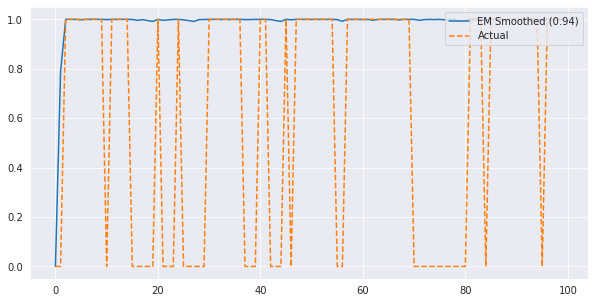

In [75]:
f, ax = plt.subplots(figsize=(10,5))
auc = roc_auc_score(X, all_gammas2[:,1])
ax.plot(all_gammas2[:,1], label ='EM Smoothed ({:.2f})'.format(auc))
ax.plot(X, ls='--', label='Actual')

plt.legend(frameon=True, loc=1)
plt.show()

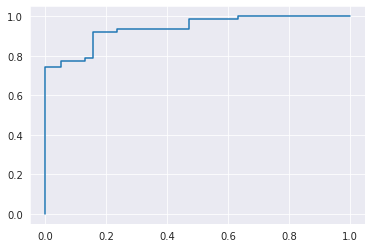

In [76]:
sns.set_style('darkgrid')
fpr, tpr, threshold = roc_curve(X, all_gammas2[:,1])
plt.plot(fpr, tpr)
plt.show()